Import library

In [2]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

Baca Dataset

In [3]:
path = "D202.csv"
df = pd.read_csv(path)
df

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN
...,...,...,...,...,...,...,...,...
70363,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,$0.00,NaN
70364,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,$0.01,NaN
70365,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,$0.01,NaN
70366,Electric usage,10/24/2018,23:30,23:44,0.03,kWh,$0.01,NaN


Cek null value & cek info dataset

In [5]:
print(df.isnull().sum())
df.info()

TYPE              0
DATE              0
START TIME        0
END TIME          0
USAGE             0
UNITS             0
COST              0
NOTES         70368
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
 7   NOTES       0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 4.3+ MB


Pisah kolom label dan fitur

In [61]:
dates = df['DATE'].values #label
temp = df['USAGE'].values #fitur

Buat plot untuk cek pola timeseries dan fitur

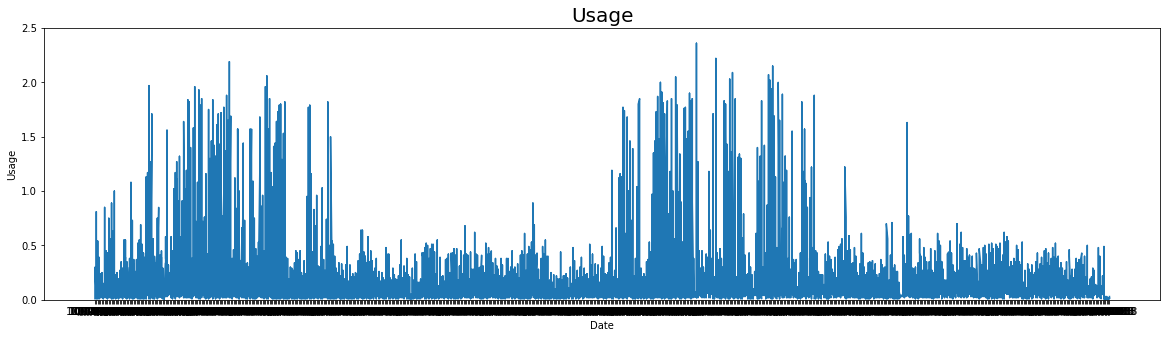

In [62]:
plt.figure(figsize=(20,5))
plt.plot(dates, temp)
plt.ylim([0,2.5])
plt.ylabel('Usage')
plt.xlabel('Date')
plt.title('Usage', fontsize=20);

Bagi data training dan data testing

In [63]:
from sklearn.model_selection import train_test_split
x_latih, x_test, y_latih, y_test = train_test_split(temp, dates, test_size = 0.2)

Total pembagian data

In [64]:
print("Training data: ", len(x_latih))
print("Val data: ", len(x_test))

Training data:  56294
Val data:  14074


In [65]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

Bagi data train & data validation

In [85]:
train_set = windowed_dataset(x_latih, window_size=60, batch_size=128, shuffle_buffer=1000)
val_set = windowed_dataset(x_test, window_size=60, batch_size=128, shuffle_buffer=1000)

Buat Model

In [93]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

MAE Terkecil (10% skala data)

In [87]:
mae_terkecil = (temp.max() - temp.min()) * 10/100 #0.236
print(mae_terkecil)

0.236


Menggunakan Callback

In [91]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<mae_terkecil and logs.get('val_mae')<mae_terkecil):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [94]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=15, 
                    validation_data = val_set,
                    batch_size=128,
                    callbacks=[callbacks])

Epoch 1/15
440/440 [==============================] - 71s 151ms/step - loss: 0.0229 - mae: 0.0970 - val_loss: 0.0213 - val_mae: 0.0989

MAE dari model < 10% skala data


Plot Akurasi dan Loss

Plot Akurasi

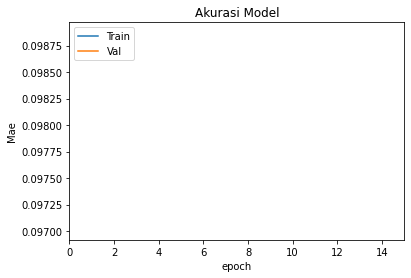

In [98]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.xlim([0,15])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Plot Loss

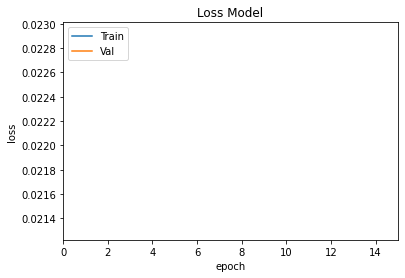

In [99]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xlim([0,15])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()